<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experiments</a></span><ul class="toc-item"><li><span><a href="#de-Bézenac-et-al,-2019:-CNN-with-warp-mapping-on-SST-data" data-toc-modified-id="de-Bézenac-et-al,-2019:-CNN-with-warp-mapping-on-SST-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>de Bézenac et al, 2019: CNN with warp mapping on SST data</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Regularization-Coefficients" data-toc-modified-id="Regularization-Coefficients-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Regularization Coefficients</a></span><ul class="toc-item"><li><span><a href="#Magnitude" data-toc-modified-id="Magnitude-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Magnitude</a></span></li><li><span><a href="#Divergence" data-toc-modified-id="Divergence-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>Divergence</a></span></li><li><span><a href="#Smoothness" data-toc-modified-id="Smoothness-2.1.2.3"><span class="toc-item-num">2.1.2.3&nbsp;&nbsp;</span>Smoothness</a></span></li></ul></li><li><span><a href="#Training-with-Squared-Error-Loss" data-toc-modified-id="Training-with-Squared-Error-Loss-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Training with Squared Error Loss</a></span></li><li><span><a href="#Training-with-Regularized-Squared-Error-Loss" data-toc-modified-id="Training-with-Regularized-Squared-Error-Loss-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Training with Regularized Squared Error Loss</a></span></li></ul></li></ul></li></ul></div>

# Imports and setup functions

In [1]:
import os

os.chdir("/projectnb/labci/Lucia/rainfall-pde-ml/")

In [2]:
import datetime
import math
import torch

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function, Variable
from functools import reduce
from tqdm import trange

#from src.dataloader.SSTLoader import SSTLoader
from src.datasets.ERA5Dataset import ERA5Dataset
from src.models.BezConv import BezConv
from src.temperature.Experiment import Experiment
from src.temperature import utils

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

torch.cuda.get_device_name(0)

True
1
0


'Tesla V100-PCIE-16GB'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
def datadir(x):
    return "/projectnb/labci/Lucia/data/" + x

# Experiments

## de Bézenac et al, 2019: CNN with warp mapping on SST data

### Setup: load files in dataset

In [6]:
torch.manual_seed(42)

temp_files = os.listdir(datadir("era5_npy/temperature_resized/"))
for i in range(len(temp_files)):
    temp_files[i] = datadir("era5_npy/temperature_resized/") + temp_files[i]
temp_files.sort()

wind_files = os.listdir(datadir("era5_npy/wind_resized/"))
for i in range(len(wind_files)):
    wind_files[i] = datadir("era5_npy/wind_resized/") + wind_files[i]
wind_files.sort()

dict1 = {"temperature": temp_files, "wind": wind_files}
dict2 = {0: "temperature", 1: "wind"}
k = 4
E5D = ERA5Dataset(naming_conv="ERA5_npy", variable_files=dict1, variable_ids=dict2, history=k, hour=3)

### Create dataloaders 

In [7]:
split = E5D.train_val_test_split([0.8, 0.1, 0.1])
Train = split[0]
Val = split[1]
Test = split[2]

training_loader = torch.utils.data.DataLoader(Train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(Val, batch_size=16, shuffle=True)  
test_loader = torch.utils.data.DataLoader(Test, batch_size=16, shuffle=False)

Splitting dataset for variable 0: temperature
Splitting dataset for variable 1: wind


In [8]:
X, y, W = next(iter(training_loader))
print(f"Data batch shape: {X.size()}")
print(f"Ends batch shape: {y.size()}")
print(f"Wind batch shape: {W.size()}")

Data batch shape: torch.Size([16, 4, 64, 64])
Ends batch shape: torch.Size([16, 64, 64])
Wind batch shape: torch.Size([16, 2, 64, 64])


In [9]:
print(len(training_loader))
print(len(val_loader))
print(len(test_loader))

433
54
54


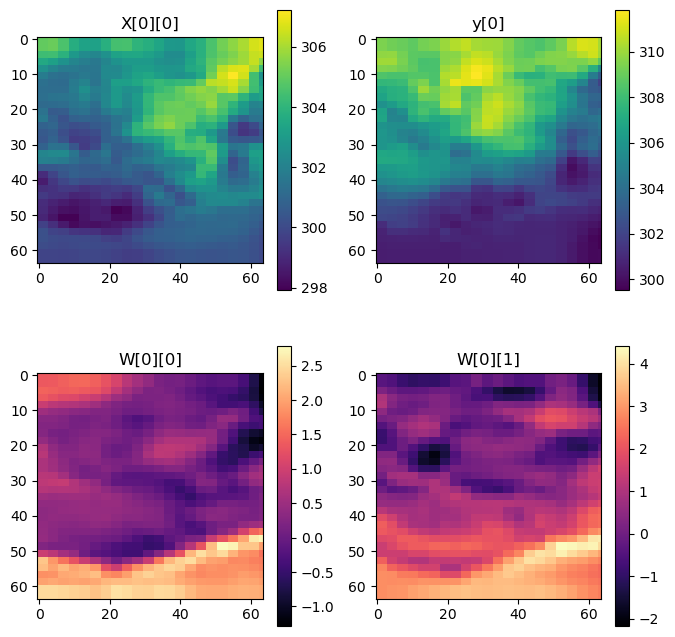

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

xplot = ax1.imshow(X[0][0])
ax1.set_title("X[0][0]")
fig.colorbar(xplot, ax=ax1)

yplot = ax2.imshow(y[0])
ax2.set_title("y[0]")
fig.colorbar(yplot, ax=ax2)

wuplot = ax3.imshow(W[0][0], cmap="magma")
ax3.set_title("W[0][0]")
fig.colorbar(wuplot, ax=ax3)

wvplot = ax4.imshow(W[0][1], cmap="magma")
ax4.set_title("W[0][1]")
fig.colorbar(wvplot, ax=ax4)

In [11]:
try:
    os.mkdir("/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today()))
except FileExistsError as e:
    print("Already ran experiments today.")
finally:
    path = "/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today())

Already ran experiments today.


### Experiment 0: No Regularization, Constrain Wind

In [12]:
net0 = BezConv(device, [0,0,0], hist=4).to(device)
optim=torch.optim.Adam(net0.parameters(), lr=1e-4, weight_decay=4e-4)
exp_w0 = Experiment(name="GhanaTemp_wind_50", 
                    trainset=training_loader,
                    valset=val_loader, 
                    testset=None,
                    model=net0,
                    regloss=False,
                    test_loss=nn.MSELoss(reduction="mean"),  
                    optimizer=optim,
                    outdir=path,
                    device=device,
                    windloss=True)

exp_w0.run(epochs=50)
exp_w0.visualize_examples(val_loader, "validationImage")  
exp_w0.plot_loss("Performance in Training", "Epoch", ["train", "val"], "lossPlot")

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-12-14/GhanaTemp_wind_50
Running experiment: GhanaTemp_wind_50...
Training over 50 epochs...


Training:   2%|▏         | 1/50 [01:18<1:04:17, 78.71s/Epoch]

Mean Training Loss: 12788117.60551
Validation Loss:  359577.76042
Saved checkpoint at epoch 0


Training:   4%|▍         | 2/50 [02:36<1:02:20, 77.93s/Epoch]

Mean Training Loss: 1088262.57376
Validation Loss:  281696.78472


Training:   6%|▌         | 3/50 [03:53<1:00:52, 77.70s/Epoch]

Mean Training Loss: 824118.47553
Validation Loss:  252989.28385


Training:   8%|▊         | 4/50 [05:10<59:29, 77.59s/Epoch]  

Mean Training Loss: 744381.01667
Validation Loss:  248801.92216


Training:  10%|█         | 5/50 [06:28<58:09, 77.53s/Epoch]

Mean Training Loss: 1347555.17509
Validation Loss:  269195.82755


Training:  12%|█▏        | 6/50 [07:45<56:49, 77.48s/Epoch]

Mean Training Loss: 743113.7736
Validation Loss:  242732.59259


Training:  14%|█▍        | 7/50 [09:03<55:32, 77.51s/Epoch]

Mean Training Loss: 674252.00224
Validation Loss:  239422.42173


Training:  16%|█▌        | 8/50 [10:20<54:14, 77.48s/Epoch]

Mean Training Loss: 646236.2303
Validation Loss:  235912.21513


Training:  18%|█▊        | 9/50 [11:38<52:56, 77.48s/Epoch]

Mean Training Loss: 629108.57672
Validation Loss:  235801.94575


Training:  20%|██        | 10/50 [12:55<51:41, 77.53s/Epoch]

Mean Training Loss: 616724.72312
Validation Loss:  234129.91233


Training:  22%|██▏       | 11/50 [14:13<50:21, 77.47s/Epoch]

Mean Training Loss: 608978.8142
Validation Loss:  231913.27865


Training:  24%|██▍       | 12/50 [15:30<49:02, 77.43s/Epoch]

Mean Training Loss: 602256.02324
Validation Loss:  231347.45949


Training:  26%|██▌       | 13/50 [16:48<47:45, 77.45s/Epoch]

Mean Training Loss: 593689.97535
Validation Loss:  234549.89598


Training:  28%|██▊       | 14/50 [18:05<46:28, 77.47s/Epoch]

Mean Training Loss: 589015.52562
Validation Loss:  233897.2581


Training:  30%|███       | 15/50 [19:22<45:10, 77.43s/Epoch]

Mean Training Loss: 581760.78212
Validation Loss:  230909.53212


Training:  32%|███▏      | 16/50 [20:40<43:52, 77.42s/Epoch]

Mean Training Loss: 577422.33285
Validation Loss:  230721.60127


Training:  34%|███▍      | 17/50 [21:57<42:33, 77.39s/Epoch]

Mean Training Loss: 578207.90156
Validation Loss:  230605.20747


Training:  36%|███▌      | 18/50 [23:14<41:16, 77.38s/Epoch]

Mean Training Loss: 570656.57924
Validation Loss:  230049.70515


Training:  38%|███▊      | 19/50 [24:32<39:59, 77.40s/Epoch]

Mean Training Loss: 567113.47387
Validation Loss:  231363.91522


Training:  40%|████      | 20/50 [25:49<38:42, 77.41s/Epoch]

Mean Training Loss: 562381.92287
Validation Loss:  232177.82378


Training:  42%|████▏     | 21/50 [27:07<37:25, 77.44s/Epoch]

Mean Training Loss: 560035.85302
Validation Loss:  229984.85243


Training:  44%|████▍     | 22/50 [28:24<36:08, 77.44s/Epoch]

Mean Training Loss: 556679.97539
Validation Loss:  228074.76939


Training:  46%|████▌     | 23/50 [29:42<34:50, 77.41s/Epoch]

Mean Training Loss: 554522.03796
Validation Loss:  228720.25203


Training:  48%|████▊     | 24/50 [30:59<33:34, 77.48s/Epoch]

Mean Training Loss: 549906.48235
Validation Loss:  225862.01678


Training:  50%|█████     | 25/50 [32:17<32:15, 77.42s/Epoch]

Mean Training Loss: 548122.70222
Validation Loss:  229550.47352


Training:  52%|█████▏    | 26/50 [33:34<30:57, 77.38s/Epoch]

Mean Training Loss: 544976.6676
Validation Loss:  228499.47049


Training:  54%|█████▍    | 27/50 [34:51<29:39, 77.36s/Epoch]

Mean Training Loss: 544527.56806
Validation Loss:  229370.52141


Training:  56%|█████▌    | 28/50 [36:08<28:21, 77.34s/Epoch]

Mean Training Loss: 543491.08567
Validation Loss:  226557.37587


Training:  58%|█████▊    | 29/50 [37:26<27:04, 77.34s/Epoch]

Mean Training Loss: 539706.48928
Validation Loss:  227627.85286


Training:  60%|██████    | 30/50 [38:43<25:46, 77.35s/Epoch]

Mean Training Loss: 536418.95547
Validation Loss:  225962.31308


Training:  62%|██████▏   | 31/50 [40:00<24:29, 77.34s/Epoch]

Mean Training Loss: 536046.92076
Validation Loss:  248551.33507


Training:  64%|██████▍   | 32/50 [41:18<23:12, 77.37s/Epoch]

Mean Training Loss: 532716.42422
Validation Loss:  226144.65422


Training:  66%|██████▌   | 33/50 [42:35<21:55, 77.38s/Epoch]

Mean Training Loss: 532558.20285
Validation Loss:  225348.5026


Training:  68%|██████▊   | 34/50 [43:53<20:37, 77.36s/Epoch]

Mean Training Loss: 529661.18521
Validation Loss:  228232.47468


Training:  70%|███████   | 35/50 [45:10<19:20, 77.34s/Epoch]

Mean Training Loss: 527443.03867
Validation Loss:  225570.98727


Training:  72%|███████▏  | 36/50 [46:28<18:05, 77.51s/Epoch]

Mean Training Loss: 524996.90683
Validation Loss:  230896.76317


Training:  74%|███████▍  | 37/50 [47:45<16:46, 77.46s/Epoch]

Mean Training Loss: 523565.54713
Validation Loss:  226494.14337


Training:  76%|███████▌  | 38/50 [49:02<15:29, 77.42s/Epoch]

Mean Training Loss: 522660.62466
Validation Loss:  231915.01765


Training:  78%|███████▊  | 39/50 [50:20<14:11, 77.39s/Epoch]

Mean Training Loss: 517992.5944
Validation Loss:  226938.5191


Training:  80%|████████  | 40/50 [51:37<12:53, 77.35s/Epoch]

Mean Training Loss: 515676.06957
Validation Loss:  291562.16609


Training:  82%|████████▏ | 41/50 [52:54<11:36, 77.34s/Epoch]

Mean Training Loss: 513312.18313
Validation Loss:  221640.00622


Training:  84%|████████▍ | 42/50 [54:12<10:18, 77.35s/Epoch]

Mean Training Loss: 511055.98308
Validation Loss:  228452.96209


Training:  86%|████████▌ | 43/50 [55:29<09:01, 77.34s/Epoch]

Mean Training Loss: 508958.07149
Validation Loss:  229598.5515


Training:  88%|████████▊ | 44/50 [56:47<07:44, 77.39s/Epoch]

Mean Training Loss: 507840.64539
Validation Loss:  223305.35692


Training:  90%|█████████ | 45/50 [58:04<06:27, 77.52s/Epoch]

Mean Training Loss: 504606.6862
Validation Loss:  229860.45327


Training:  92%|█████████▏| 46/50 [59:22<05:10, 77.50s/Epoch]

Mean Training Loss: 502562.29161
Validation Loss:  224151.30657


Training:  94%|█████████▍| 47/50 [1:00:39<03:52, 77.44s/Epoch]

Mean Training Loss: 498931.94021
Validation Loss:  223725.03892


Training:  96%|█████████▌| 48/50 [1:01:57<02:34, 77.48s/Epoch]

Mean Training Loss: 496490.17252
Validation Loss:  228734.00014


Training:  98%|█████████▊| 49/50 [1:03:14<01:17, 77.44s/Epoch]

Mean Training Loss: 496204.97994
Validation Loss:  222389.69719


Training: 100%|██████████| 50/50 [1:04:32<00:00, 77.45s/Epoch]

Mean Training Loss: 491915.45933
Validation Loss:  224949.37876


### Experiment 1: No Regularization, No Wind Constraints

In [12]:
# TODO: create new bool in constructor for dataloader -> windloss is not enough to check for
# how many variables are in dataloaders

# TODO: also plot last input image to make sure it's not copying

net1 = BezConv(device, [0,0,0], hist=4).to(device)
optim=torch.optim.Adam(net1.parameters(), lr=1e-4, weight_decay=4e-4)
exp_nw = Experiment(name="GhanaTemp_noWind_50", 
                    trainset=training_loader,
                    valset=val_loader, 
                    testset=None,
                    model=net1,
                    regloss=False,
                    test_loss=nn.MSELoss(reduction="mean"),  
                    optimizer=optim,
                    outdir=path,
                    device=device,
                    windloss=False)

exp_nw.run(epochs=50)
exp_nw.visualize_examples(val_loader, "validationImage")  
exp_nw.plot_loss("Performance in Training", "Epoch", ["train", "val"], "lossPlot")

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-12-14/GhanaTemp_noWind_50
Running experiment: GhanaTemp_noWind_50...
Training over 50 epochs...


Training:   2%|▏         | 1/50 [01:18<1:04:04, 78.47s/Epoch]

Mean Training Loss: 11255810.61843
Validation Loss:  416339.74421
Saved checkpoint at epoch 0


Training:   4%|▍         | 2/50 [02:35<1:02:11, 77.74s/Epoch]

Mean Training Loss: 328265.03103
Validation Loss:  312180.15046


Training:   6%|▌         | 3/50 [03:53<1:00:46, 77.58s/Epoch]

Mean Training Loss: 267399.93357
Validation Loss:  267066.11516


Training:   8%|▊         | 4/50 [05:10<59:28, 77.57s/Epoch]  

Mean Training Loss: 298101.29117
Validation Loss:  286057.52922


Training:  10%|█         | 5/50 [06:28<58:12, 77.62s/Epoch]

Mean Training Loss: 250304.06622
Validation Loss:  257213.24392


Training:  12%|█▏        | 6/50 [07:46<56:55, 77.63s/Epoch]

Mean Training Loss: 237183.68016
Validation Loss:  254483.62587


Training:  14%|█▍        | 7/50 [09:03<55:37, 77.61s/Epoch]

Mean Training Loss: 229709.73952
Validation Loss:  236858.69126


Training:  16%|█▌        | 8/50 [10:21<54:21, 77.65s/Epoch]

Mean Training Loss: 226039.30185
Validation Loss:  250679.28935


Training:  18%|█▊        | 9/50 [11:38<52:58, 77.52s/Epoch]

Mean Training Loss: 392346.03679
Validation Loss:  266121.59433


Training:  20%|██        | 10/50 [13:06<53:44, 80.62s/Epoch]

Mean Training Loss: 235728.47281
Validation Loss:  243531.14062


Training:  22%|██▏       | 11/50 [14:23<51:49, 79.74s/Epoch]

Mean Training Loss: 232068.35553
Validation Loss:  233875.79832


Training:  24%|██▍       | 12/50 [15:41<50:03, 79.03s/Epoch]

Mean Training Loss: 221257.85263
Validation Loss:  225251.69575


Training:  26%|██▌       | 13/50 [16:58<48:26, 78.54s/Epoch]

Mean Training Loss: 215830.68566
Validation Loss:  220423.05295


Training:  28%|██▊       | 14/50 [18:15<46:53, 78.16s/Epoch]

Mean Training Loss: 234831.06508
Validation Loss:  241225.02546


Training:  30%|███       | 15/50 [19:33<45:26, 77.89s/Epoch]

Mean Training Loss: 218315.1974
Validation Loss:  224629.47859


Training:  32%|███▏      | 16/50 [20:50<44:04, 77.78s/Epoch]

Mean Training Loss: 213791.47048
Validation Loss:  217779.7011


Training:  34%|███▍      | 17/50 [22:07<42:41, 77.62s/Epoch]

Mean Training Loss: 212891.41067
Validation Loss:  223582.44473


Training:  36%|███▌      | 18/50 [23:25<41:20, 77.52s/Epoch]

Mean Training Loss: 210430.81165
Validation Loss:  225187.29051


Training:  38%|███▊      | 19/50 [24:42<40:00, 77.42s/Epoch]

Mean Training Loss: 211642.24928
Validation Loss:  213974.54514


Training:  40%|████      | 20/50 [25:59<38:41, 77.38s/Epoch]

Mean Training Loss: 208724.48862
Validation Loss:  214998.27228


Training:  42%|████▏     | 21/50 [27:17<37:23, 77.35s/Epoch]

Mean Training Loss: 206123.37231
Validation Loss:  209309.45457


Training:  44%|████▍     | 22/50 [28:34<36:04, 77.32s/Epoch]

Mean Training Loss: 204612.78037
Validation Loss:  208228.23322


Training:  46%|████▌     | 23/50 [29:51<34:46, 77.29s/Epoch]

Mean Training Loss: 1095305.96797
Validation Loss:  251312.33536


Training:  48%|████▊     | 24/50 [31:08<33:29, 77.29s/Epoch]

Mean Training Loss: 230245.3647
Validation Loss:  232025.80035


Training:  50%|█████     | 25/50 [32:44<34:29, 82.78s/Epoch]

Mean Training Loss: 221741.24262
Validation Loss:  223713.66782


Training:  52%|█████▏    | 26/50 [34:01<32:29, 81.21s/Epoch]

Mean Training Loss: 218969.51684
Validation Loss:  220357.67578


Training:  54%|█████▍    | 27/50 [35:19<30:41, 80.06s/Epoch]

Mean Training Loss: 216597.52015
Validation Loss:  237143.57957


Training:  56%|█████▌    | 28/50 [36:36<29:03, 79.27s/Epoch]

Mean Training Loss: 214458.17104
Validation Loss:  216566.75984


Training:  58%|█████▊    | 29/50 [37:54<27:32, 78.69s/Epoch]

Mean Training Loss: 211418.90446
Validation Loss:  213983.19184


Training:  60%|██████    | 30/50 [39:11<26:05, 78.28s/Epoch]

Mean Training Loss: 209665.67721
Validation Loss:  213432.82292


Training:  62%|██████▏   | 31/50 [40:28<24:41, 77.99s/Epoch]

Mean Training Loss: 237977.87317
Validation Loss:  228121.7908


Training:  64%|██████▍   | 32/50 [41:46<23:21, 77.86s/Epoch]

Mean Training Loss: 216614.20808
Validation Loss:  219021.81163


Training:  70%|███████   | 35/50 [45:38<19:25, 77.67s/Epoch]

Mean Training Loss: 207358.38017
Validation Loss:  210688.25868


Training:  72%|███████▏  | 36/50 [46:56<18:06, 77.59s/Epoch]

Mean Training Loss: 205759.89021
Validation Loss:  209761.97786


Training:  74%|███████▍  | 37/50 [48:13<16:48, 77.59s/Epoch]

Mean Training Loss: 205416.00705
Validation Loss:  218272.55527


Training:  76%|███████▌  | 38/50 [49:31<15:30, 77.56s/Epoch]

Mean Training Loss: 205754.86852
Validation Loss:  207376.87543


Training:  78%|███████▊  | 39/50 [50:48<14:12, 77.50s/Epoch]

Mean Training Loss: 206988.20706
Validation Loss:  220475.59028


Training:  80%|████████  | 40/50 [52:06<12:55, 77.54s/Epoch]

Mean Training Loss: 206671.39972
Validation Loss:  209026.49826


Training:  82%|████████▏ | 41/50 [53:24<11:38, 77.57s/Epoch]

Mean Training Loss: 211666.95755
Validation Loss:  209891.19227


Training:  84%|████████▍ | 42/50 [54:41<10:20, 77.55s/Epoch]

Mean Training Loss: 205988.04745
Validation Loss:  218300.06554


Training:  86%|████████▌ | 43/50 [55:59<09:03, 77.59s/Epoch]

Mean Training Loss: 210904.46415
Validation Loss:  213520.72483


Training:  88%|████████▊ | 44/50 [57:16<07:45, 77.55s/Epoch]

Mean Training Loss: 207082.85984
Validation Loss:  208083.36386


Training:  90%|█████████ | 45/50 [58:34<06:27, 77.53s/Epoch]

Mean Training Loss: 204932.7754
Validation Loss:  238917.62211


Training:  92%|█████████▏| 46/50 [59:51<05:10, 77.54s/Epoch]

Mean Training Loss: 206003.89311
Validation Loss:  223292.54311


Training:  94%|█████████▍| 47/50 [1:01:09<03:52, 77.53s/Epoch]

Mean Training Loss: 206061.20045
Validation Loss:  209554.50796


Training:  96%|█████████▌| 48/50 [1:02:26<02:34, 77.47s/Epoch]

Mean Training Loss: 208877.26815
Validation Loss:  225904.96687


Training:  98%|█████████▊| 49/50 [1:03:44<01:17, 77.45s/Epoch]

Mean Training Loss: 208500.95543
Validation Loss:  253665.57378


Training: 100%|██████████| 50/50 [1:05:02<00:00, 78.04s/Epoch]

Mean Training Loss: 204554.99053
Validation Loss:  207962.42549
